In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [63]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        
        dists = dists/dists.std(dim=1, keepdim=True)
#         dists = torch.exp(-dists)
        
#         print(dists.shape)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        return dists
    
    def reverse(self, x):
        ### here x is the distance, so weighted distance is the reversed mode
        ##### for a single input, y = mean(x_i * center_i : for i in range(num_centers))
        pass

In [64]:
dt = DistanceTransform(784, 784)

In [65]:
dists = dt(torch.randn(2, 784))

In [66]:
dists.shape

torch.Size([2, 784])

In [67]:
dists-dists.min(dim=1, keepdim=True)[0]

tensor([[1.6159, 2.6825, 4.9393,  ..., 3.1204, 2.3331, 1.7863],
        [3.4000, 3.4945, 2.9877,  ..., 2.7457, 2.2654, 3.8329]],
       grad_fn=<SubBackward0>)

In [68]:
dists.std(dim=1, keepdim=True)

tensor([[1.0000],
        [1.0000]], grad_fn=<StdBackward>)

In [69]:
list(dt.parameters())

[Parameter containing:
 tensor([[-0.4297,  0.2689,  0.6685,  ...,  0.1888,  0.1953, -0.0356],
         [ 0.0385, -0.2565,  0.1959,  ..., -0.2007,  0.0988,  0.2997],
         [ 0.2912,  0.2037,  0.3346,  ..., -0.0122,  0.0878, -0.1541],
         ...,
         [-0.4858,  0.0316,  0.0260,  ...,  0.2496, -0.0726, -0.1672],
         [-0.1385,  0.1653,  0.0843,  ...,  0.1392,  1.0002, -0.2069],
         [-0.1187, -0.0847,  0.0546,  ..., -0.0563, -0.9246,  0.3273]],
        requires_grad=True)]

In [70]:
dt(torch.randn(2, 784)).shape

torch.Size([2, 784])

In [71]:
x=train_dataset[[3,7]][0]
dists = dt(x)
x.std(), dists.std()

(tensor(0.3944), tensor(0.9997, grad_fn=<StdBackward>))

In [72]:
dists.max(), dists.min()

(tensor(3.1798, grad_fn=<MaxBackward1>),
 tensor(-3.3358, grad_fn=<MinBackward1>))

In [73]:
dt.centers.shape

torch.Size([784, 784])

In [74]:
### single variable inverse
x = torch.randn(1, 2)
x

tensor([[-0.1655,  2.1134]])

In [75]:
centers = torch.randn(2, 2) ## output_dim / num_centers, input_dim
y = torch.cdist(x, centers.t())  
y.shape

torch.Size([1, 2])

In [76]:
y

tensor([[2.4656, 3.3867]])

In [77]:
weighted_sum = 0
weight = (1/y).sum()
for i in range(len(centers)):
    weighted_sum += centers[i]*(1/y[0,i])/weight
weighted_sum

tensor([-0.6329, -0.4193])

In [78]:
##### test for inverse
x = torch.randn(2, 4)

In [79]:
centers = torch.randn(4, 4) ## output_dim / num_centers, input_dim
y = torch.cdist(x, centers)  
y.shape

torch.Size([2, 4])

In [80]:
y

tensor([[3.0244, 5.6457, 2.2987, 3.1269],
        [3.7476, 5.4727, 3.0792, 2.5314]])

In [81]:
(y.unsqueeze(2)*centers).shape

torch.Size([2, 4, 4])

In [82]:
z = (y.unsqueeze(2)*centers.t()).sum(dim=2)/y.sum(dim=1, keepdim=True)
z.shape

torch.Size([2, 4])

In [83]:
z

tensor([[-0.2434,  0.7788,  0.3573, -0.7583],
        [-0.2867,  0.7176,  0.4549, -0.5834]])

In [84]:
x

tensor([[-1.1133,  0.5919, -0.8591,  1.4990],
        [-1.1090, -0.2308,  0.2579,  1.9542]])

In [85]:
model = nn.Sequential(
                DistanceTransform(784, 20),
#                 nn.Linear(784, 20),
                nn.BatchNorm1d(20),
                nn.Linear(20, 200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=20, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=50, out_features=10, bias=True)
)

In [86]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [87]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.45242664217948914


  2%|▎         | 1/40 [00:03<02:02,  3.15s/it]

Train Acc:74.93%, Test Acc:80.05%

Epoch: 1:0,  Loss:0.4885425269603729


  5%|▌         | 2/40 [00:06<01:59,  3.14s/it]

Train Acc:82.13%, Test Acc:82.33%

Epoch: 2:0,  Loss:0.5004724860191345


  8%|▊         | 3/40 [00:09<01:57,  3.17s/it]

Train Acc:83.78%, Test Acc:82.63%

Epoch: 3:0,  Loss:0.6083713173866272


 10%|█         | 4/40 [00:12<01:54,  3.17s/it]

Train Acc:84.60%, Test Acc:83.81%

Epoch: 4:0,  Loss:0.7236096858978271


 12%|█▎        | 5/40 [00:15<01:50,  3.16s/it]

Train Acc:85.45%, Test Acc:84.35%

Epoch: 5:0,  Loss:0.32939568161964417


 15%|█▌        | 6/40 [00:18<01:47,  3.17s/it]

Train Acc:85.79%, Test Acc:84.77%

Epoch: 6:0,  Loss:0.4675801396369934


 18%|█▊        | 7/40 [00:22<01:44,  3.16s/it]

Train Acc:86.37%, Test Acc:84.87%

Epoch: 7:0,  Loss:0.50433748960495


 20%|██        | 8/40 [00:25<01:42,  3.20s/it]

Train Acc:86.86%, Test Acc:85.26%

Epoch: 8:0,  Loss:0.2880982458591461


 22%|██▎       | 9/40 [00:28<01:39,  3.21s/it]

Train Acc:87.05%, Test Acc:85.48%

Epoch: 9:0,  Loss:0.27250149846076965


 25%|██▌       | 10/40 [00:31<01:35,  3.19s/it]

Train Acc:87.33%, Test Acc:85.50%

Epoch: 10:0,  Loss:0.3593248128890991


 28%|██▊       | 11/40 [00:35<01:32,  3.20s/it]

Train Acc:87.60%, Test Acc:85.52%

Epoch: 11:0,  Loss:0.3633747100830078


 30%|███       | 12/40 [00:38<01:29,  3.20s/it]

Train Acc:87.95%, Test Acc:85.77%

Epoch: 12:0,  Loss:0.18339073657989502


 32%|███▎      | 13/40 [00:41<01:26,  3.20s/it]

Train Acc:88.01%, Test Acc:85.85%

Epoch: 13:0,  Loss:0.15107928216457367


 35%|███▌      | 14/40 [00:44<01:23,  3.21s/it]

Train Acc:88.27%, Test Acc:86.09%

Epoch: 14:0,  Loss:0.28696927428245544


 38%|███▊      | 15/40 [00:47<01:20,  3.22s/it]

Train Acc:88.36%, Test Acc:86.42%

Epoch: 15:0,  Loss:0.19578757882118225


 40%|████      | 16/40 [00:51<01:17,  3.24s/it]

Train Acc:88.60%, Test Acc:86.14%

Epoch: 16:0,  Loss:0.2260109931230545


 42%|████▎     | 17/40 [00:54<01:14,  3.25s/it]

Train Acc:88.82%, Test Acc:86.61%

Epoch: 17:0,  Loss:0.29904815554618835


 45%|████▌     | 18/40 [00:57<01:11,  3.24s/it]

Train Acc:88.84%, Test Acc:86.49%

Epoch: 18:0,  Loss:0.17723363637924194


 48%|████▊     | 19/40 [01:00<01:08,  3.24s/it]

Train Acc:89.14%, Test Acc:86.83%

Epoch: 19:0,  Loss:0.17608129978179932


 50%|█████     | 20/40 [01:04<01:04,  3.25s/it]

Train Acc:89.34%, Test Acc:86.88%

Epoch: 20:0,  Loss:0.2484656721353531


 52%|█████▎    | 21/40 [01:07<01:01,  3.24s/it]

Train Acc:89.42%, Test Acc:86.71%

Epoch: 21:0,  Loss:0.16981174051761627


 55%|█████▌    | 22/40 [01:10<00:58,  3.23s/it]

Train Acc:89.49%, Test Acc:86.91%

Epoch: 22:0,  Loss:0.26761573553085327


 57%|█████▊    | 23/40 [01:13<00:54,  3.23s/it]

Train Acc:89.51%, Test Acc:86.90%

Epoch: 23:0,  Loss:0.35945412516593933


 60%|██████    | 24/40 [01:16<00:51,  3.21s/it]

Train Acc:89.59%, Test Acc:86.98%

Epoch: 24:0,  Loss:0.17078468203544617


 62%|██████▎   | 25/40 [01:20<00:48,  3.21s/it]

Train Acc:89.85%, Test Acc:87.10%

Epoch: 25:0,  Loss:0.10679695010185242


 65%|██████▌   | 26/40 [01:23<00:44,  3.17s/it]

Train Acc:89.82%, Test Acc:87.05%

Epoch: 26:0,  Loss:0.2915150821208954


 68%|██████▊   | 27/40 [01:26<00:41,  3.16s/it]

Train Acc:89.98%, Test Acc:86.93%

Epoch: 27:0,  Loss:0.24539947509765625


 70%|███████   | 28/40 [01:29<00:37,  3.16s/it]

Train Acc:90.13%, Test Acc:87.04%

Epoch: 28:0,  Loss:0.3077031373977661


 72%|███████▎  | 29/40 [01:32<00:34,  3.17s/it]

Train Acc:90.12%, Test Acc:87.11%

Epoch: 29:0,  Loss:0.2234448790550232


 75%|███████▌  | 30/40 [01:35<00:31,  3.16s/it]

Train Acc:90.29%, Test Acc:87.35%

Epoch: 30:0,  Loss:0.3675171136856079


 78%|███████▊  | 31/40 [01:39<00:28,  3.17s/it]

Train Acc:90.38%, Test Acc:87.50%

Epoch: 31:0,  Loss:0.33141160011291504


 80%|████████  | 32/40 [01:42<00:25,  3.14s/it]

Train Acc:90.44%, Test Acc:86.97%

Epoch: 32:0,  Loss:0.22216816246509552


 82%|████████▎ | 33/40 [01:45<00:22,  3.15s/it]

Train Acc:90.51%, Test Acc:87.19%

Epoch: 33:0,  Loss:0.2157043069601059


 85%|████████▌ | 34/40 [01:48<00:18,  3.15s/it]

Train Acc:90.55%, Test Acc:87.31%

Epoch: 34:0,  Loss:0.06787452846765518


 88%|████████▊ | 35/40 [01:51<00:15,  3.14s/it]

Train Acc:90.64%, Test Acc:87.47%

Epoch: 35:0,  Loss:0.3065556287765503


 90%|█████████ | 36/40 [01:54<00:12,  3.15s/it]

Train Acc:90.80%, Test Acc:87.43%

Epoch: 36:0,  Loss:0.16488230228424072


 92%|█████████▎| 37/40 [01:57<00:09,  3.17s/it]

Train Acc:90.84%, Test Acc:87.29%

Epoch: 37:0,  Loss:0.24120096862316132


 95%|█████████▌| 38/40 [02:01<00:06,  3.18s/it]

Train Acc:91.01%, Test Acc:87.61%

Epoch: 38:0,  Loss:0.1631173938512802


 98%|█████████▊| 39/40 [02:04<00:03,  3.17s/it]

Train Acc:90.99%, Test Acc:87.57%

Epoch: 39:0,  Loss:0.15092377364635468


100%|██████████| 40/40 [02:07<00:00,  3.19s/it]

Train Acc:91.03%, Test Acc:87.35%

	-> MAX Train Acc 91.02833333333334 ; Test Acc 87.61


In [38]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 98.1367 ; Test Acc 89.22 ### after distance normalization
# -> MAX Train Acc 98.6317 ; Test Acc 89.36 ### after distance normalization and -ve exp
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [ ]:
### with 20 input units
-> MAX Train Acc 90.65833333333333 ; Test Acc 87.45 ## 20 centroids
-> MAX Train Acc 92.34166666666667 ; Test Acc 87.54 ## 20 linear transforms

In [88]:
model.eval()
dists = model[0](train_dataset[[0,3,7]][0].to(device))
dists = model[1](dists)
model.train()
dists.shape

torch.Size([3, 20])

In [89]:
dists.mean()

tensor(0.0400, device='cuda:1', grad_fn=<MeanBackward0>)

In [90]:
dists.std()

tensor(1.2883, device='cuda:1', grad_fn=<StdBackward>)

In [91]:
dists[0]

tensor([ 0.1633,  0.3907, -1.1940,  1.9178, -1.8180,  0.2989,  1.3358,  1.4357,
        -0.6802, -1.8179,  0.1074, -1.0373, -0.3553,  1.2614,  2.2907,  0.7587,
         0.1721, -1.6489,  0.2524, -1.2011], device='cuda:1',
       grad_fn=<SelectBackward>)

## Generate adversarial example

In [92]:
_xx, _tt = iter(train_loader).next()

tensor(2)

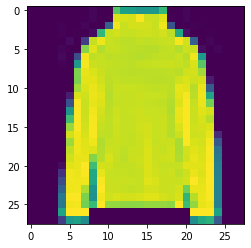

In [93]:
i = 8
plt.imshow(_xx[i].reshape(28,28))
_tt[i]

In [94]:
xx = _xx[i:i+1,:]
tt = _tt[i:i+1]

target_class = 0
advt = tt*0+target_class

In [95]:
model.eval()

X = torch.autograd.Variable(xx, requires_grad=True)
yy = model(X.to(device))

In [96]:
torch.argmax(yy.data.cpu(), dim=1), tt, advt

(tensor([4]), tensor([2]), tensor([0]))

In [97]:
loss = criterion(yy, advt.to(device))

xx_grad = torch.autograd.grad(outputs=loss, inputs=X,
#                             grad_outputs=torch.ones_like(self.Y),
                            only_inputs=True, retain_graph=True, create_graph=True)[0]

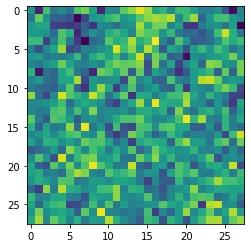

In [98]:
plt.imshow(xx_grad.data.cpu().reshape(28,28))

In [99]:
signed_grad = torch.sign(xx_grad.data.cpu())
# signed_grad = xx_grad.data.cpu()

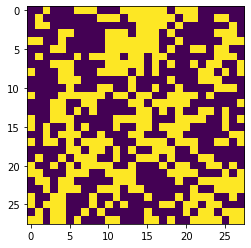

In [100]:
plt.imshow(signed_grad.reshape(28,28))

In [101]:
epsilon = 0.1
pertubation = xx - epsilon*signed_grad
xx_adv = pertubation
xx_adv = torch.clamp(pertubation, 0, 1)

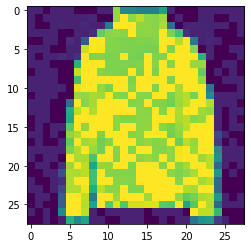

In [102]:
plt.imshow(xx_adv.reshape(28,28))

In [103]:
yy_adv = model(xx_adv.to(device))

In [104]:
yy_adv.argmax(dim=1)

tensor([8], device='cuda:1')

In [105]:
tt

tensor([2])